# Data description: 
It is a monthly count of riders for the Portland public transportation system. The website states that it is from January 1960 through June 1969, with 114 observations.

# Workflow:
- Load the Time Series (TS) by Pandas Library

 # 1)  Exploration of Time Series:
- TS Line, Histogram & Probability plots
- TS Line & Box plots by intervals
- TS Lag plots
- Check the stationarity of TS, by:
     - Plotting rolling mean & standard deviation
     - Perform Dickey-Fuller test

 #  2) Seasonal ARIMA model:
- Build and evaluate the Seasonal ARIMA model: 
     - Grid-Search for the best ARIMA parameters
     - Fit the best ARIMA model
     - Evaluate model by in-sample prediction: Calculate RMSE
- Forecast the future trend: Out-of-sample prediction

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
%matplotlib inline

import os
os.environ['PYTHONHASHSEED'] = '0'

# for the reproducable results:
np.random.seed(42)
rn.seed(42)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data using Series.from_csv
from pandas import Series
#TS = Series.from_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/daily-minimum-temperatures.csv', header=0)

# Load data using pandas.read_csv
# in case, specify your own date parsing function and use the date_parser argument
from pandas import read_csv
from pandas import datetime

#def parser(x):
#    return datetime.strptime('190'+x, '%Y-%m')
TS = read_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/portland-oregon-average-monthly-.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

print(TS.head())

Month
1960-01-01    648
1960-02-01    646
1960-03-01    639
1960-04-01    654
1960-05-01    630
Name: Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114, dtype: int64


In [3]:
#TS=pd.to_numeric(TS, errors='coerce')
TS.dropna(inplace=True)

In [4]:
TS.describe()

count     114.000000
mean     1120.543860
std       270.888317
min       613.000000
25%       885.000000
50%      1158.000000
75%      1340.000000
max      1558.000000
Name: Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114, dtype: float64

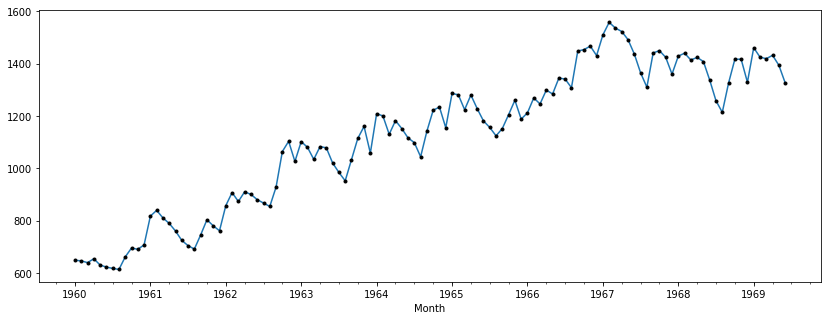

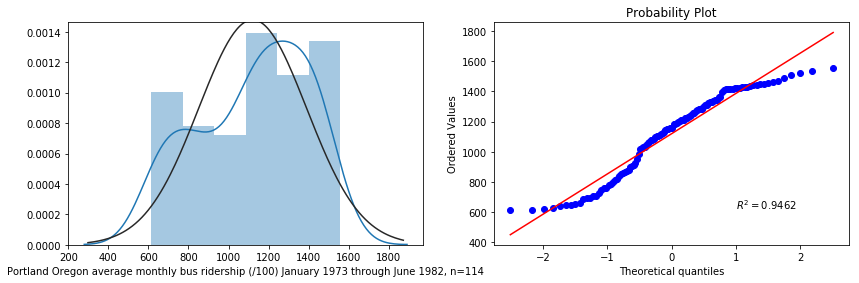

In [5]:
# Time Series Line Plot: _________________________________________
plt.figure(figsize=(14, 5))
TS.plot()
TS.plot(style="k.")
plt.show()

#Time Series Histogram and Density Plot:
fig = plt.figure(figsize=(14, 9))
ax1 = fig.add_subplot(221)
ax1=sns.distplot(TS, fit=stats.norm)
    
ax2 = fig.add_subplot(222)
res=stats.probplot(TS, plot=ax2, rvalue=True)

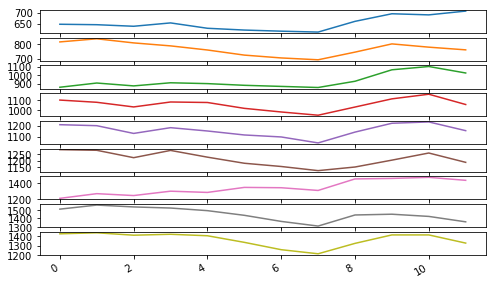

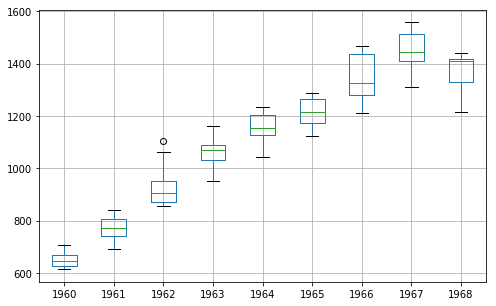

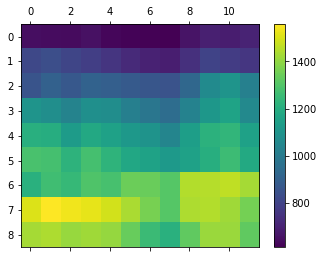

In [6]:
# Time Series Line, Box and Whisker Plots by Intervals: _________________________________________________
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper

groups = TS[:'1968'].groupby(TimeGrouper('Y'))
years = DataFrame()

for name, group in groups:
    years[ name.year]=group.values[0:12]
    
years.plot(subplots=True, legend=False, figsize=(8,5))
plt.show()

years.boxplot(figsize=(8,5))
plt.show()

plt.matshow(years.T, interpolation=None, aspect='auto')
plt.colorbar()
plt.show()

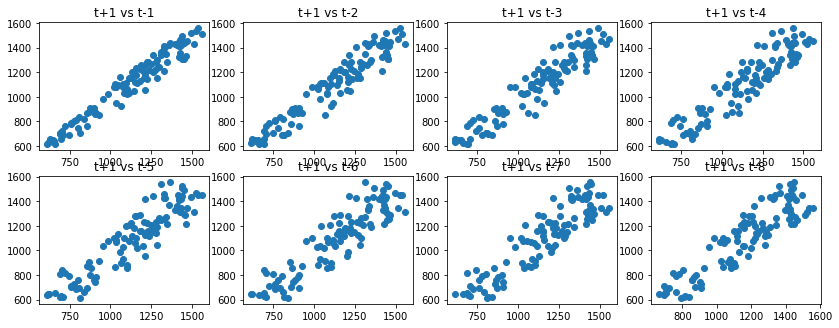

In [7]:
# Time Series Lag Scatter Plots: ____________________________________________________
from pandas import concat
from pandas.plotting import scatter_matrix

plt.figure(figsize=(14, 8))

values = DataFrame(TS.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = concat(columns, axis=1)
columns = ['t+1']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)

for i in range(1,(lags + 1)):
    ax = plt.subplot(340 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)

plt.show()

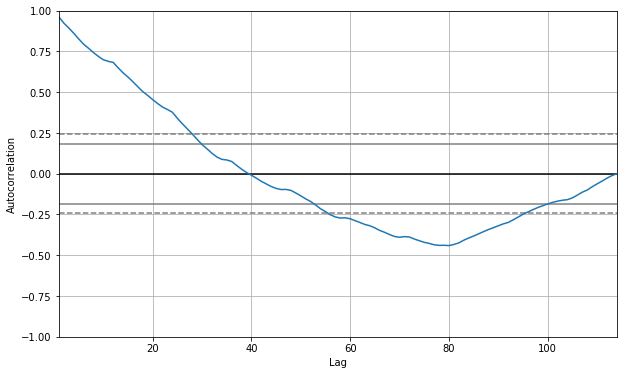

In [8]:
#Time Series Autocorrelation Plot: ________________________________________________________
from pandas.tools.plotting import autocorrelation_plot

plt.figure(figsize=(10, 6))
autocorrelation_plot(TS)
plt.show()

In [9]:
# To check the stationarity of Time Series: _________________________________________________
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, win=12):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=win).mean()
    rolstd = timeseries.rolling(window=win).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

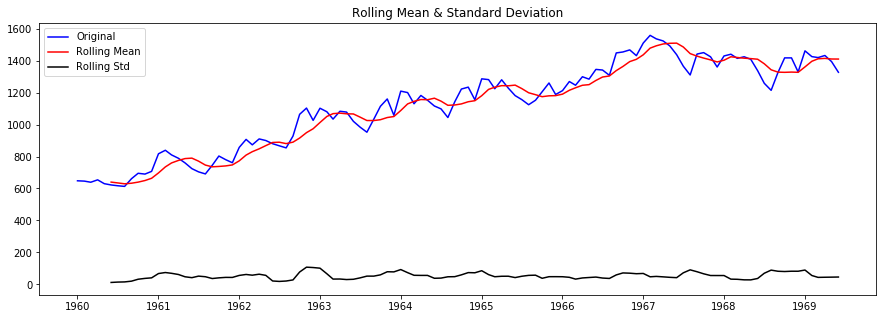

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [10]:
test_stationarity(TS, win=6)

In [11]:
import statsmodels.api as sm

In [12]:
# load passenger data set and save to DataFrame
df = pd.read_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/portland-oregon-average-monthly-.csv', header=0, index_col=0, parse_dates=True, sep=',')
 
# create Series object
y = df['Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114']

y_train = y[:'1968-01']
y_test = y['1968-01':]
# split into training and test sets
#y=TS.values
#y_train = TS[:'1958'].values
#y_test = TS['1959':].values

In [13]:
import itertools
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
 
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [14]:
# Grid-Search for the best ARIMA parameters:

import sys
import warnings
warnings.filterwarnings("ignore")
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

from sklearn.metrics import mean_squared_error
L=[]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
            res = tmp_mdl.fit(n_jobs=-1)
            pred = res.get_prediction(start=pd.to_datetime('1960-01-01'), 
                          end=pd.to_datetime('1968-01-01'),
                          dynamic=False)
            
            
            RMSE= np.sqrt(mean_squared_error(y_train.values, pred.predicted_mean.values))
            print('RMSE= ', RMSE, ',  ', '(p,d,q)= ', param, ',  ','(P,D,Q)= ', param_seasonal, sep='')
            L.append([RMSE,param, param_seasonal] )
            
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
                
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
            
print("\n Best SARIMAX{}x{} model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

RMSE= 1107.758729174298,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (0, 0, 0, 12)
RMSE= 265.3616283761331,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (0, 1, 0, 12)
RMSE= 262.4382506091802,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (0, 1, 1, 12)
RMSE= 276.4431959680804,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (0, 2, 0, 12)
RMSE= 259.79784463154823,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (1, 1, 0, 12)
RMSE= 251.18451705160615,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (1, 1, 1, 12)
RMSE= 257.76349741173834,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (1, 2, 0, 12)
RMSE= 250.83159513734077,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (2, 1, 0, 12)
RMSE= 248.0926484759637,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (2, 1, 1, 12)
RMSE= 257.1206610203599,  (p,d,q)= (0, 0, 0),  (P,D,Q)= (2, 2, 0, 12)
RMSE= 583.6574207139179,  (p,d,q)= (0, 0, 1),  (P,D,Q)= (0, 0, 0, 12)
RMSE= 338.5249323368078,  (p,d,q)= (0, 0, 2),  (P,D,Q)= (0, 0, 0, 12)
RMSE= 249.59052730770503,  (p,d,q)= (0, 0, 2),  (P,D,Q)= (0, 2, 0, 12)
RMSE= 244.8809291429841,  (p,d,q)= (0, 0, 2),  (P,D,Q)= (1, 2, 0, 12)
RMSE= 244.80658

RMSE= 215.43617120346508,  (p,d,q)= (1, 0, 0),  (P,D,Q)= (1, 1, 1, 12)
RMSE= 241.46449414855243,  (p,d,q)= (1, 0, 0),  (P,D,Q)= (1, 2, 0, 12)
RMSE= 216.2774916685543,  (p,d,q)= (1, 0, 0),  (P,D,Q)= (2, 1, 0, 12)
RMSE= 215.47029612788302,  (p,d,q)= (1, 0, 0),  (P,D,Q)= (2, 1, 1, 12)
RMSE= 240.84571328035165,  (p,d,q)= (1, 0, 0),  (P,D,Q)= (2, 2, 0, 12)
RMSE= 215.57186722778079,  (p,d,q)= (1, 0, 1),  (P,D,Q)= (0, 1, 0, 12)
RMSE= 216.20703948486332,  (p,d,q)= (1, 0, 1),  (P,D,Q)= (0, 1, 1, 12)
RMSE= 237.37178157678474,  (p,d,q)= (1, 0, 1),  (P,D,Q)= (0, 2, 0, 12)
RMSE= 217.0545549516699,  (p,d,q)= (1, 0, 1),  (P,D,Q)= (1, 1, 0, 12)
RMSE= 214.90404914212937,  (p,d,q)= (1, 0, 1),  (P,D,Q)= (1, 1, 1, 12)
RMSE= 241.20062078537592,  (p,d,q)= (1, 0, 1),  (P,D,Q)= (1, 2, 0, 12)
RMSE= 215.97647383104643,  (p,d,q)= (1, 0, 1),  (P,D,Q)= (2, 1, 0, 12)
RMSE= 215.11117326372303,  (p,d,q)= (1, 0, 1),  (P,D,Q)= (2, 1, 1, 12)
RMSE= 240.4355316646645,  (p,d,q)= (1, 0, 1),  (P,D,Q)= (2, 2, 0, 12)
RMSE= 215

RMSE= 88.66992902988451,  (p,d,q)= (1, 2, 2),  (P,D,Q)= (1, 1, 0, 12)
RMSE= 88.06499987466428,  (p,d,q)= (1, 2, 2),  (P,D,Q)= (1, 1, 1, 12)
RMSE= 105.295165566486,  (p,d,q)= (1, 2, 2),  (P,D,Q)= (1, 2, 0, 12)
RMSE= 103.67666396345419,  (p,d,q)= (1, 2, 2),  (P,D,Q)= (1, 2, 1, 12)
RMSE= 82.2321702148994,  (p,d,q)= (1, 2, 2),  (P,D,Q)= (2, 0, 0, 12)
RMSE= 81.98721139651333,  (p,d,q)= (1, 2, 2),  (P,D,Q)= (2, 0, 1, 12)
RMSE= 88.43797145216374,  (p,d,q)= (1, 2, 2),  (P,D,Q)= (2, 1, 0, 12)
RMSE= 88.04385511570695,  (p,d,q)= (1, 2, 2),  (P,D,Q)= (2, 1, 1, 12)
RMSE= 104.28802737126843,  (p,d,q)= (1, 2, 2),  (P,D,Q)= (2, 2, 0, 12)
RMSE= 103.65309733951784,  (p,d,q)= (1, 2, 2),  (P,D,Q)= (2, 2, 1, 12)
RMSE= 215.57327924794473,  (p,d,q)= (2, 0, 0),  (P,D,Q)= (0, 1, 0, 12)
RMSE= 216.17234226074535,  (p,d,q)= (2, 0, 0),  (P,D,Q)= (0, 1, 1, 12)
RMSE= 237.69338678307076,  (p,d,q)= (2, 0, 0),  (P,D,Q)= (0, 2, 0, 12)
RMSE= 217.0773224131299,  (p,d,q)= (2, 0, 0),  (P,D,Q)= (1, 1, 0, 12)
RMSE= 214.947436

RMSE= 82.12213888786808,  (p,d,q)= (2, 2, 2),  (P,D,Q)= (1, 0, 1, 12)
RMSE= 88.67147509894221,  (p,d,q)= (2, 2, 2),  (P,D,Q)= (1, 1, 0, 12)
RMSE= 88.06036165697061,  (p,d,q)= (2, 2, 2),  (P,D,Q)= (1, 1, 1, 12)
RMSE= 105.29256920303573,  (p,d,q)= (2, 2, 2),  (P,D,Q)= (1, 2, 0, 12)
RMSE= 103.7307540124438,  (p,d,q)= (2, 2, 2),  (P,D,Q)= (1, 2, 1, 12)
RMSE= 82.24045430169951,  (p,d,q)= (2, 2, 2),  (P,D,Q)= (2, 0, 0, 12)
RMSE= 88.43990225478905,  (p,d,q)= (2, 2, 2),  (P,D,Q)= (2, 1, 0, 12)
RMSE= 88.04245545916142,  (p,d,q)= (2, 2, 2),  (P,D,Q)= (2, 1, 1, 12)
RMSE= 104.25880190467142,  (p,d,q)= (2, 2, 2),  (P,D,Q)= (2, 2, 0, 12)
RMSE= 103.62869163910902,  (p,d,q)= (2, 2, 2),  (P,D,Q)= (2, 2, 1, 12)

 Best SARIMAX(0, 2, 1)x(1, 2, 1, 12) model - AIC:767.7706795424174


In [26]:
L.sort()
L[0:10]

[[74.50533490191978, (2, 1, 2), (2, 0, 0, 12)],
 [74.65241540453674, (2, 1, 2), (2, 0, 1, 12)],
 [74.89047146749571, (2, 1, 2), (1, 0, 1, 12)],
 [74.89444177084538, (2, 1, 1), (2, 0, 1, 12)],
 [74.91105313098971, (1, 1, 2), (2, 0, 1, 12)],
 [74.91478604471946, (1, 1, 1), (2, 0, 1, 12)],
 [74.97071166630042, (0, 1, 2), (2, 0, 1, 12)],
 [74.99288706120952, (2, 1, 0), (2, 0, 1, 12)],
 [74.997043445074, (2, 1, 1), (1, 0, 1, 12)],
 [75.03034250826626, (1, 1, 2), (1, 0, 1, 12)]]

In [16]:
# define SARIMAX model and fit it to the data
mdl = sm.tsa.statespace.SARIMAX(y_train,
                                order=(2, 1, 2),
                                seasonal_order=(2, 0, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()

In [17]:
# print statistics
print(res.aic)
print(res.summary())

977.7224865858707
                                                               Statespace Model Results                                                               
Dep. Variable:     Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114   No. Observations:                   97
Model:                                                                         SARIMAX(2, 1, 2)x(2, 0, 1, 12)   Log Likelihood                -480.861
Date:                                                                                        Wed, 18 Jul 2018   AIC                            977.722
Time:                                                                                                17:10:44   BIC                            998.237
Sample:                                                                                            01-01-1960   HQIC                           986.015
                                                                            

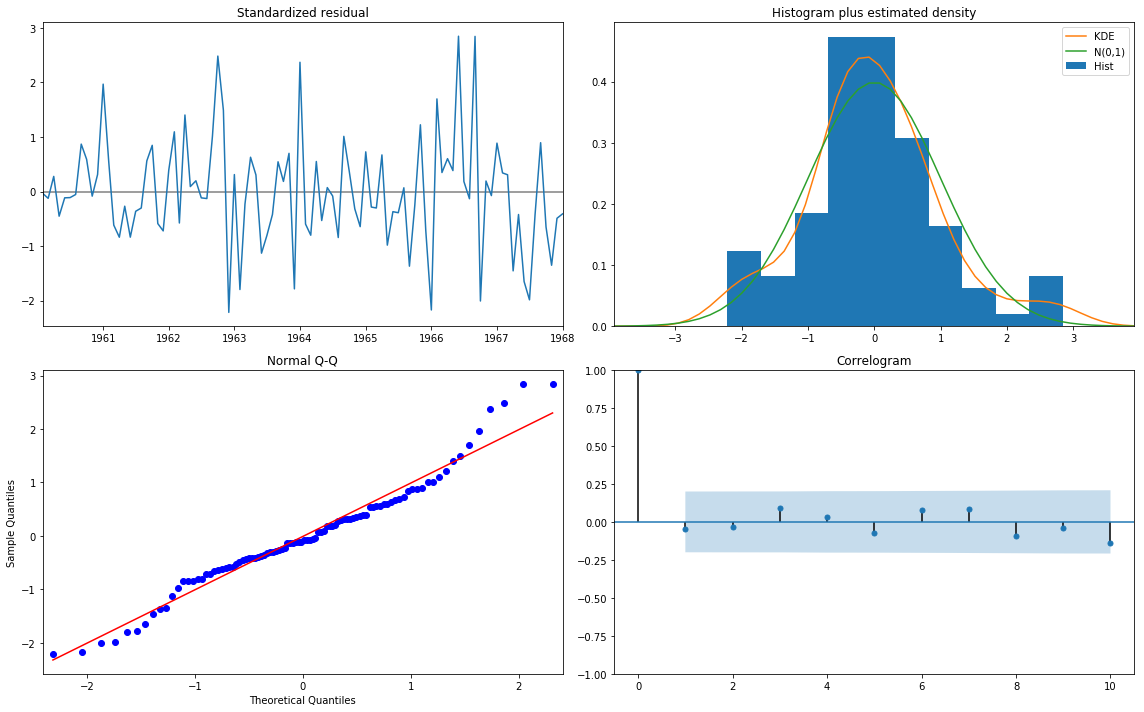

In [18]:
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

Validation RMSE :  51.0953529213998


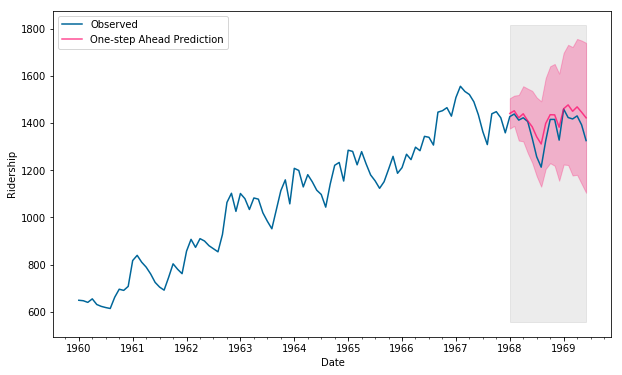

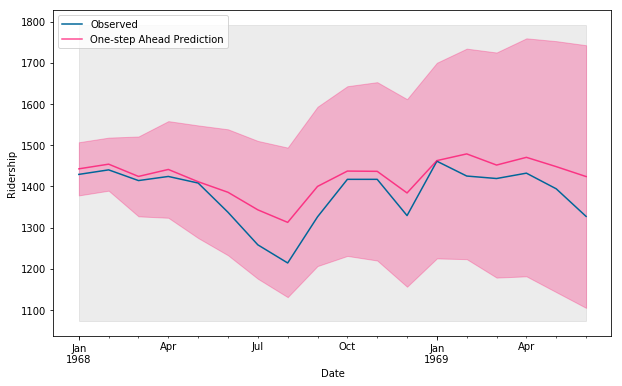

In [19]:
# fit model to data
# in-sample-prediction and confidence bounds
pred = res.get_prediction(start=pd.to_datetime('1968-01-01'), 
                          end=pd.to_datetime('1969-06-01'),
                          dynamic=False)
pred_ci = pred.conf_int()

print('Validation RMSE : ', np.sqrt(mean_squared_error(y['1968-01-01': ].values, pred.predicted_mean.values)))

# plot in-sample-prediction
plt.figure(figsize=(10, 6))
ax = y['1960':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');
 
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
               pred_ci.iloc[:, 0], 
               pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);

# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1968-01-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date')
ax.set_ylabel('Ridership')
plt.legend(loc='upper left')
plt.show()

# plot in-sample-prediction
plt.figure(figsize=(10, 6))
ax = y['1968':].plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');

# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
               pred_ci.iloc[:, 0], 
               pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);

# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1968-01-01'), y.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date')
ax.set_ylabel('Ridership')
plt.legend(loc='upper left')
plt.show()

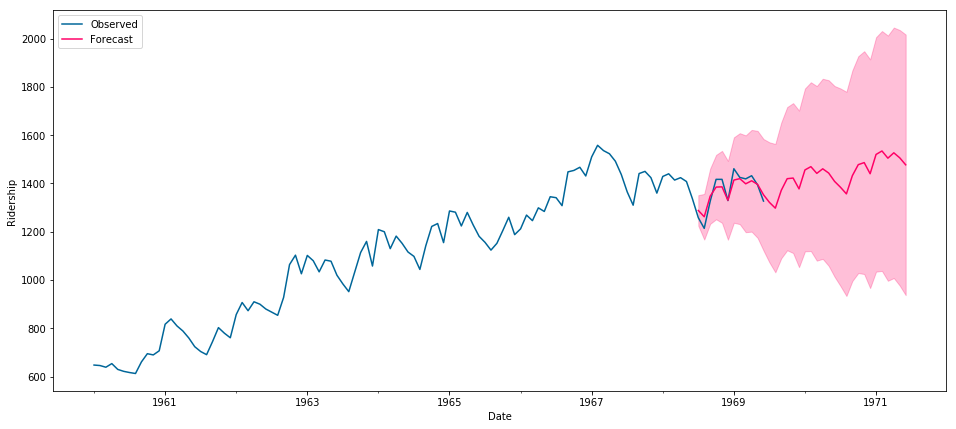

In [29]:
# Forecast (out-of-sample prediction)
mdl = sm.tsa.statespace.SARIMAX(y[:'1968-06'],
                                order=(2, 1, 2),
                                seasonal_order=(2, 0, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()

# get forecast 120 steps ahead in future
pred_uc = res.get_forecast(steps=36, dynamics=False)
 
# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
 
# plot time series and long-term forecast
ax = y.plot(label='Observed', figsize=(16, 7), color='#006699');
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Ridership');
plt.legend(loc='upper left')
plt.show()